In [1]:
import numpy as np
import tensorflow as tf 
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import check_random_state

# Load the MNIST Data and Train Logistic Regression
Adapted from https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html. MNIST has a training set with 60,000 examples and a test set with 10,000 samples. We will combine these and split them manually.
- Relabel: 0-4 gets 0 and 5-9 gets 1
- Split into train (9%), validation (1%), test (90%)
- Use train/validation for logistic regression

In [64]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
print(np.shape(X), np.shape(y))

(70000, 784) (70000,)


In [65]:
y = list(map(int, y))
y = list(map(lambda x: x > 4, y))
y = list(map(int, y))
y = np.array(y)

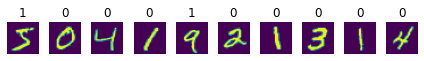

In [66]:
def show_digits(X, y, i):
    fig, ax = plt.subplots(1, len(i), sharex=True)
    for k, j in enumerate(i):
        ax[k].imshow(X[j].reshape(28, 28))
        ax[k].set_title(y[j])
        ax[k].axis('off')
    plt.tight_layout()
    plt.show()
        
show_digits(X, y, range(10))

In [67]:
n_train = 6500
n_valid = 500
n_test = len(X) - n_train - n_valid

random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

X_train, X_valid_tmp, y_train, y_valid_tmp = train_test_split(
    X, y, train_size=n_train)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_valid_tmp, y_valid_tmp, train_size=n_valid)

print(np.shape(X_train), np.shape(X_valid), np.shape(X_test))
print(np.shape(y_train), np.shape(y_valid), np.shape(y_test))

(6500, 784) (500, 784) (63000, 784)
(6500,) (500,) (63000,)


In [71]:
scaler = StandardScaler() # MinMaxScaler() performs worse
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

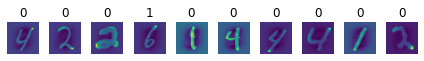

In [72]:
show_digits(X_train, y_train, range(10))

Test score: 0.8460


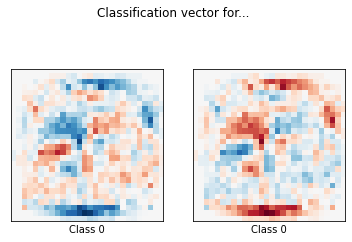

In [74]:
clf = LogisticRegression(solver='saga', penalty='l1', C=100. / n_train, tol=0.001, max_iter=10000)
clf.fit(X_train, y_train)

sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(X_valid, y_valid)
print("Test score: %.4f" % score)

coef = clf.coef_.copy()
scale = np.abs(coef).max()
fig, ax = plt.subplots(1, 2, sharex=True)
ax[0].imshow(coef.reshape(28, 28), interpolation='nearest',
               cmap=plt.cm.RdBu, vmin=-scale, vmax=scale)
ax[1].imshow((coef * -1).reshape(28, 28), interpolation='nearest',
               cmap=plt.cm.RdBu, vmin=-scale, vmax=scale)
ax[0].set_xticks(())
ax[0].set_yticks(())
ax[0].set_xlabel('Class 0')
ax[1].set_xticks(())
ax[1].set_yticks(())
ax[1].set_xlabel('Class 0')
plt.suptitle('Classification vector for...')
plt.show()

# Generate NN Samples
- Split test data into another train (55000) / valid (3000) / test (5000)
- Run the classifier on the digits to generate (x, y, p*)

In [75]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_test, y_test, train_size=55000)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_valid, y_valid, train_size=3000)
print(np.shape(X_train), np.shape(X_valid), np.shape(X_test))
print(np.shape(y_train), np.shape(y_valid), np.shape(y_test))

(55000, 784) (3000, 784) (5000, 784)
(55000,) (3000,) (5000,)


In [76]:
p_star_train = clf.predict_proba(X_train)[:, 1]
p_star_valid = clf.predict_proba(X_valid)[:, 1]
p_star_test = clf.predict_proba(X_test)[:, 1]

In [77]:
X_train = np.reshape(X_train, (-1, 28, 28, 1))
X_valid = np.reshape(X_valid, (-1, 28, 28, 1))
X_test = np.reshape(X_test, (-1, 28, 28, 1))
print(np.shape(X_train), np.shape(X_valid), np.shape(X_test))

(55000, 28, 28, 1) (3000, 28, 28, 1) (5000, 28, 28, 1)


In [78]:
y_train = np.random.binomial(1, p_star_train)
y_valid = np.random.binomial(1, p_star_valid)
y_test = np.random.binomial(1, p_star_test)

# h and w Training Loop
For the NN, we use the CNN LeNet-5 from the LeCun's 1998 [paper](https://ieeexplore.ieee.org/document/726791)
- Outer loop: train hat f using (x_i, y_i) from the train/validation set
- Inner loop: freese hat h and train w_new using (x_i, p*_i)
- Metrics: plot the MSE and loss for hat f during training, plot the MSE of w_new * h during training, plot a calibration curve for both at the end of training

In [133]:
def custom_loss(y_true, y_pred):
    y_true = tf.cast(y_true, np.float32)
    y_pred = y_pred[0]
    x = -y_true * tf.math.log(y_pred + 1e-16) - (1 - y_true) * tf.math.log(1 - y_pred + 1e-16)
    return tf.reduce_mean(x)

In [136]:
# Construct model layers
base_model = keras.models.Sequential([
    keras.layers.Conv2D(6, kernel_size=5, strides=1,  activation='tanh', input_shape=(28, 28, 1), 
                        padding='same', kernel_initializer=keras.initializers.RandomUniform()),
    keras.layers.AveragePooling2D(),
    keras.layers.Conv2D(16, kernel_size=5, strides=1, activation='tanh', padding='valid', 
                        kernel_initializer=keras.initializers.RandomUniform()),
    keras.layers.AveragePooling2D(),
    keras.layers.Flatten()
], name='LeNet-5')

lenet_top = keras.models.Sequential([
    keras.layers.Dense(100, activation='tanh', kernel_initializer=keras.initializers.RandomUniform()), 
    keras.layers.Dense(84, activation='tanh', kernel_initializer=keras.initializers.RandomUniform()),
    keras.layers.Dense(1, activation='sigmoid', kernel_initializer=keras.initializers.RandomUniform())
], name='w_hat')

# Learning rate scheduler
def schedule(epoch, lr):
    if epoch > 0 and epoch % 3 == 0:
        return lr / 2.
    return lr
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(schedule, verbose=1)

# Generate the f_hat model
inputs = keras.Input(shape=(28, 28, 1), name='input')
lenet_5_model = lenet_top(base_model(inputs))
lenet_5_model = keras.Model(inputs, lenet_5_model)
lenet_5_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                      #loss=custom_loss,
                      loss=keras.losses.BinaryCrossentropy(),
                      metrics=[keras.metrics.MeanSquaredError(), 
                              keras.metrics.BinaryAccuracy()],
                      run_eagerly=True)
lenet_5_model.summary()

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
LeNet-5 (Sequential)         (None, 400)               2572      
_________________________________________________________________
w_hat (Sequential)           (None, 1)                 48669     
Total params: 51,241
Trainable params: 51,241
Non-trainable params: 0
_________________________________________________________________


# Train the Base Model 

In [137]:
# Train the base model
base_model.trainable = True
hist = lenet_5_model.fit(x=X_train, y=y_train, epochs=20, batch_size=128, 
                         validation_data=(X_valid, y_valid), callbacks=[lr_scheduler])

Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
430/430 [==============================] - 7s 17ms/step - loss: 0.4389 - mean_squared_error: 0.1397 - binary_accuracy: 0.8020 - val_loss: 0.3746 - val_mean_squared_error: 0.1166 - val_binary_accuracy: 0.8393
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
430/430 [==============================] - 7s 17ms/step - loss: 0.3891 - mean_squared_error: 0.1217 - binary_accuracy: 0.8331 - val_loss: 0.3788 - val_mean_squared_error: 0.1185 - val_binary_accuracy: 0.8347
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
430/430 [==============================] - 7s 17ms/step - loss: 0.3770 - mean_squared_error: 0.1178 - binary_accuracy: 0.8371 - val_loss: 0.3832 - val_mean_squared_error: 0.1200 - val_binary_accuracy: 0.8307
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0049999998882412

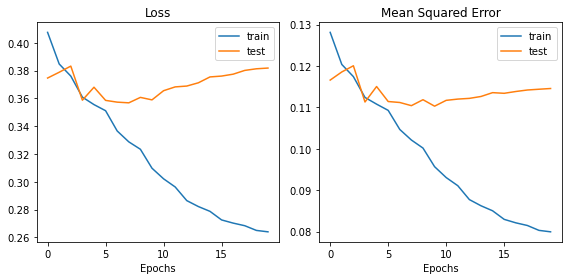

In [138]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].plot(hist.history['loss'], label='train')
ax[0].plot(hist.history['val_loss'], label='test')
ax[0].legend()
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")


ax[1].plot(hist.history['mean_squared_error'], label='train')
ax[1].plot(hist.history['val_mean_squared_error'], label='test')
ax[1].legend()
ax[1].set_title("Mean Squared Error")
ax[1].set_xlabel("Epochs")

plt.tight_layout()
plt.show()

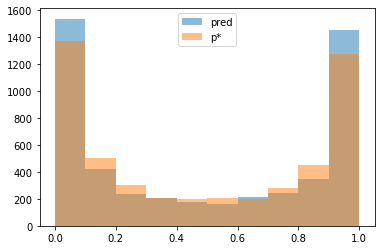

In [185]:
plt.hist(lenet_5_model.predict(X_test), label='pred', alpha=0.5)
plt.hist(p_star_test, label='p*', alpha=0.5)
plt.legend()
plt.show()

In [140]:
# Save the base model
keras.models.save_model(lenet_5_model, 'model')


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: model/assets


# Load the Saved Base Model

In [215]:
old_model = keras.models.load_model('model')

In [223]:
old_model.evaluate(X_test, y_test)

157/157 [==============================] - 0s 910us/step - loss: 0.3971 - mean_squared_error: 0.1215 - binary_accuracy: 0.8332


[0.3970566987991333, 0.12148967385292053, 0.8331999778747559]

In [224]:
old_model.evaluate(X_test, p_star_test)

157/157 [==============================] - 0s 1ms/step - loss: 0.3860 - mean_squared_error: 0.0151 - binary_accuracy: 0.0000e+00


[0.3860066831111908, 0.015139947645366192, 0.0]

In [247]:
our_top = keras.models.Sequential([
    keras.layers.Dense(100, activation='tanh', kernel_initializer=keras.initializers.RandomUniform()),
    keras.layers.Dense(84, activation='tanh', kernel_initializer=keras.initializers.RandomUniform()),
    keras.layers.Dense(1, activation='sigmoid', kernel_initializer=keras.initializers.RandomUniform())
], name='w_new')

model = keras.Sequential()
for layer in old_model.layers[:-1]: # go through until last layer
    model.add(layer)
model.trainable = False
model = our_top(model.output)
model = keras.Model(inputs=old_model.input, outputs=model)
model.summary()

Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
LeNet-5 (Sequential)         (None, 400)               2572      
_________________________________________________________________
w_new (Sequential)           (None, 1)                 48669     
Total params: 51,241
Trainable params: 48,669
Non-trainable params: 2,572
_________________________________________________________________


In [249]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=[keras.metrics.MeanSquaredError()])

# Train a New Model

In [250]:
# Train our model
hist = model.fit(x=X_train, y=p_star_train, epochs=20, batch_size=32, 
                 validation_data=(X_valid, p_star_valid), callbacks=[lr_scheduler])

Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3742 - mean_squared_error: 0.0147 - val_loss: 0.3588 - val_mean_squared_error: 0.0098
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3557 - mean_squared_error: 0.0085 - val_loss: 0.3590 - val_mean_squared_error: 0.0095
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3551 - mean_squared_error: 0.0084 - val_loss: 0.3552 - val_mean_squared_error: 0.0083
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 0.004999999888241291.
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3508 - mean_squared_error: 0.0070 - val_loss: 0.3536 - val_mean_squared_error: 0.0077
Epoch 5/

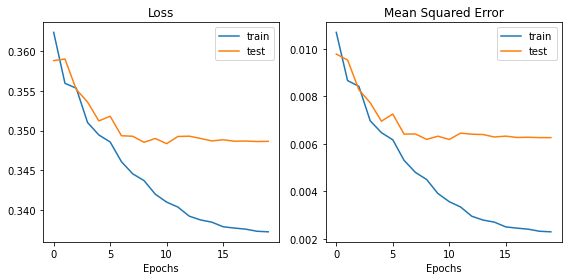

In [251]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].plot(hist.history['loss'], label='train')
ax[0].plot(hist.history['val_loss'], label='test')
ax[0].legend()
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")


ax[1].plot(hist.history['mean_squared_error'], label='train')
ax[1].plot(hist.history['val_mean_squared_error'], label='test')
ax[1].legend()
ax[1].set_title("Mean Squared Error")
ax[1].set_xlabel("Epochs")

plt.tight_layout()
plt.show()

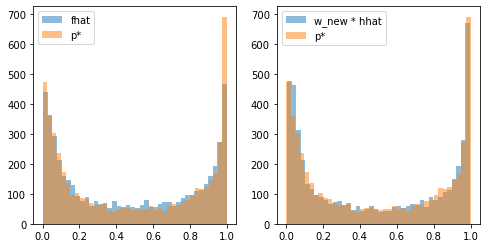

In [274]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].hist(old_model.predict(X_test), label='fhat', alpha=0.5, bins=40)
ax[0].hist(p_star_test, label='p*', alpha=0.5, bins=40)
ax[1].hist(model.predict(X_test), label='w_new * hhat', alpha=0.5, bins=40)
ax[1].hist(p_star_test, label='p*', alpha=0.5, bins=40)
ax[0].legend()
ax[1].legend()
plt.show()

In [265]:
def mse(x, y):
    return np.mean((x - y)**2)

def mae(x, y):
    return np.mean(np.abs(x - y))

print(mse(old_model.predict(X_test), p_star_test))
print(mse(model.predict(X_test), p_star_test))

print(mae(old_model.predict(X_test), p_star_test))
print(mae(model.predict(X_test), p_star_test))

0.3096890761016136
0.2925081771295092
0.4423131170761036
0.43104982759351007


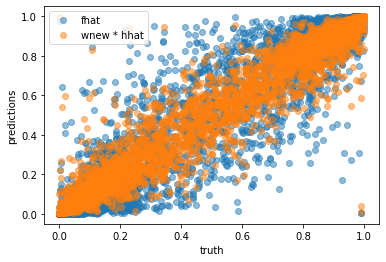

In [257]:
plt.plot(p_star_test, old_model.predict(X_test), 'o', alpha=0.5, label='fhat')
plt.plot(p_star_test, model.predict(X_test), 'o', alpha=0.5, label='wnew * hhat')
plt.legend()
plt.xlabel("truth")
plt.ylabel("predictions")
plt.show()

# Repeat with Nested Training

In [326]:
# Construct model layers
base_model = keras.models.Sequential([
    keras.layers.Conv2D(8, kernel_size=3, strides=1,  activation='relu', input_shape=(28, 28, 1), 
                        padding='same', kernel_initializer=keras.initializers.RandomNormal()),
    keras.layers.AveragePooling2D(),
    keras.layers.Conv2D(16, kernel_size=3, strides=1, activation='relu', padding='valid', 
                        kernel_initializer=keras.initializers.RandomNormal()),
    keras.layers.AveragePooling2D(),
    keras.layers.Conv2D(32, kernel_size=5, strides=1, activation='relu', padding='valid', 
                        kernel_initializer=keras.initializers.RandomNormal()),
    keras.layers.AveragePooling2D(),
    keras.layers.Flatten()
], name='LeNet-5')

lenet_top = keras.models.Sequential([
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation='relu', kernel_initializer=keras.initializers.RandomNormal()), 
    keras.layers.Dense(84, activation='relu', kernel_initializer=keras.initializers.RandomNormal()),
    keras.layers.Dense(1, activation='sigmoid', kernel_initializer=keras.initializers.RandomNormal())
], name='w_hat')

our_top = keras.models.Sequential([
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation='relu', kernel_initializer=keras.initializers.RandomNormal()),
    keras.layers.Dense(84, activation='relu', kernel_initializer=keras.initializers.RandomNormal()),
    keras.layers.Dense(1, activation='sigmoid', kernel_initializer=keras.initializers.RandomNormal())
], name='w_new')

# Learning rate scheduler
def schedule(epoch, lr):
    if epoch > 0 and epoch % 3 == 0:
        return lr / 2.
    return lr
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(schedule, verbose=1)

# Generate the f_hat model
inputs = keras.Input(shape=(28, 28, 1), name='input')
lenet_5_model = lenet_top(base_model(inputs))
lenet_5_model = keras.Model(inputs, lenet_5_model)
lenet_5_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001, amsgrad=True),
                      loss=keras.losses.BinaryCrossentropy(),
                      metrics=[keras.metrics.MeanSquaredError(), 
                              keras.metrics.BinaryAccuracy()],
                      run_eagerly=True)
lenet_5_model.summary()

n_epochs = 2  # number of outer epochs
hists1 = []
hists2 = []

for i in range(n_epochs):
    base_model.trainable = True
    hists1.append(lenet_5_model.fit(x=X_train, y=y_train, epochs=10, batch_size=128, 
                                    validation_data=(X_valid, y_valid), callbacks=[lr_scheduler]))
    
    keras.models.save_model(lenet_5_model, 'model_looped_training')
    old_model = keras.models.load_model('model_looped_training')

    model = keras.Sequential()
    for layer in old_model.layers[:-1]: # go through until last layer
        model.add(layer)
    model.trainable = False
    model = our_top(model.output)
    model = keras.Model(inputs=old_model.input, outputs=model)
    model.summary()

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=[keras.metrics.MeanSquaredError()])

    hists2.append(model.fit(x=X_train, y=p_star_train, epochs=5, batch_size=128, 
                            validation_data=(X_valid, p_star_valid)))

Model: "model_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
LeNet-5 (Sequential)         (None, 32)                14080     
_________________________________________________________________
w_hat (Sequential)           (None, 1)                 11869     
Total params: 25,949
Trainable params: 25,949
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
430/430 [==============================] - 8s 18ms/step - loss: 0.5534 - mean_squared_error: 0.1874 - binary_accuracy: 0.6962 - val_loss: 0.4131 - val_mean_squared_error: 0.1296 - val_binary_accuracy: 0.8203
Epoch 2/10

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00100

430/430 [==============================] - 7s 17ms/step - loss: 0.3572 - mean_squared_error: 0.1112 - binary_accuracy: 0.8467 - val_loss: 0.3663 - val_mean_squared_error: 0.1131 - val_binary_accuracy: 0.8467
Epoch 8/10

Epoch 00008: LearningRateScheduler reducing learning rate to 3.125000148429535e-05.
430/430 [==============================] - 7s 17ms/step - loss: 0.3569 - mean_squared_error: 0.1111 - binary_accuracy: 0.8465 - val_loss: 0.3669 - val_mean_squared_error: 0.1132 - val_binary_accuracy: 0.8470
Epoch 9/10

Epoch 00009: LearningRateScheduler reducing learning rate to 3.125000148429535e-05.
430/430 [==============================] - 7s 17ms/step - loss: 0.3558 - mean_squared_error: 0.1110 - binary_accuracy: 0.8465 - val_loss: 0.3675 - val_mean_squared_error: 0.1134 - val_binary_accuracy: 0.8480
Epoch 10/10

Epoch 00010: LearningRateScheduler reducing learning rate to 1.5625000742147677e-05.
430/430 [==============================] - 7s 17ms/step - loss: 0.3554 - mean_squared_

In [327]:
# Convert history lists to dictionaries
total_hist1 = dict()
total_hist2 = dict()

for key in hists1[0].history.keys():
    current_values = [] 
    for hist_dict in hists1:
        hist_dict = hist_dict.history
        current_values += hist_dict[key]
    total_hist1[key] = current_values
    
for key in hists2[0].history.keys():
    current_values = [] 
    for hist_dict in hists2:
        hist_dict = hist_dict.history
        current_values += hist_dict[key]
    total_hist2[key] = current_values

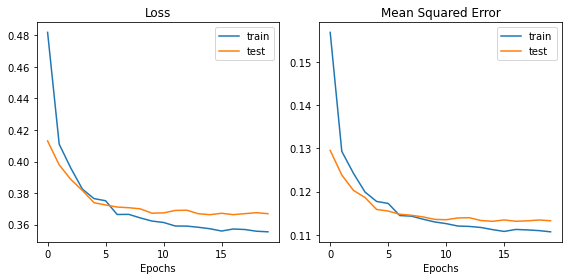

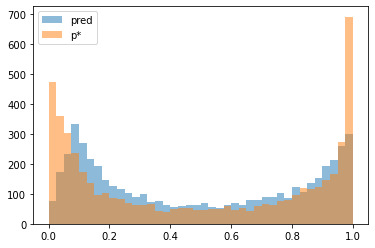

In [328]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].plot(total_hist1['loss'], label='train')
ax[0].plot(total_hist1['val_loss'], label='test')
ax[0].legend()
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")


ax[1].plot(total_hist1['mean_squared_error'], label='train')
ax[1].plot(total_hist1['val_mean_squared_error'], label='test')
ax[1].legend()
ax[1].set_title("Mean Squared Error")
ax[1].set_xlabel("Epochs")

plt.tight_layout()
plt.show()

plt.hist(lenet_5_model.predict(X_test), label='pred', alpha=0.5, bins=40)
plt.hist(p_star_test, label='p*', alpha=0.5, bins=40)
plt.legend()
plt.show()

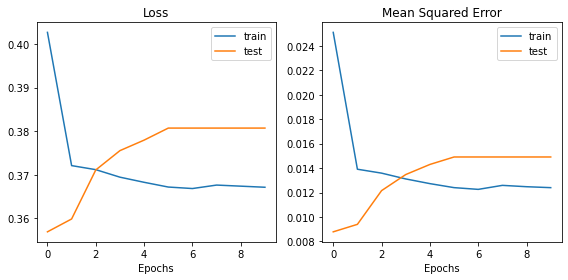

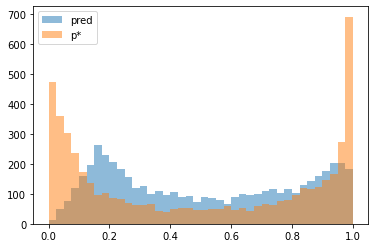

In [329]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].plot(total_hist2['loss'], label='train')
ax[0].plot(total_hist2['val_loss'], label='test')
ax[0].legend()
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")


ax[1].plot(total_hist2['mean_squared_error'], label='train')
ax[1].plot(total_hist2['val_mean_squared_error'], label='test')
ax[1].legend()
ax[1].set_title("Mean Squared Error")
ax[1].set_xlabel("Epochs")

plt.tight_layout()
plt.show()

plt.hist(model.predict(X_test), label='pred', alpha=0.5, bins=40)
plt.hist(p_star_test, label='p*', alpha=0.5, bins=40)
plt.legend()
plt.show()

In [330]:
print(mse(lenet_5_model.predict(X_test), p_star_test))
print(mse(model.predict(X_test), p_star_test))

print(mae(lenet_5_model.predict(X_test), p_star_test))
print(mae(model.predict(X_test), p_star_test))

0.2666485314714327
0.2417628329283674
0.41527319146665953
0.40243124918979467


In [334]:
# Construct model layers
base_model = keras.models.Sequential([
    keras.layers.Conv2D(8, kernel_size=3, strides=1,  activation='relu', input_shape=(28, 28, 1), 
                        padding='same', kernel_initializer=keras.initializers.GlorotNormal()),
    keras.layers.AveragePooling2D(),
    keras.layers.Conv2D(16, kernel_size=3, strides=1, activation='relu', padding='valid', 
                        kernel_initializer=keras.initializers.GlorotNormal()),
    keras.layers.AveragePooling2D(),
    keras.layers.Conv2D(32, kernel_size=5, strides=1, activation='relu', padding='valid', 
                        kernel_initializer=keras.initializers.GlorotNormal()),
    keras.layers.AveragePooling2D(),
    keras.layers.Flatten()
], name='LeNet-5')

lenet_top = keras.models.Sequential([
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation='relu', kernel_initializer=keras.initializers.GlorotNormal()), 
    keras.layers.Dense(84, activation='relu', kernel_initializer=keras.initializers.GlorotNormal()),
    keras.layers.Dense(1, activation='sigmoid', kernel_initializer=keras.initializers.GlorotNormal())
], name='w_hat')

our_top = keras.models.Sequential([
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation='relu', kernel_initializer=keras.initializers.GlorotNormal()),
    keras.layers.Dense(84, activation='relu', kernel_initializer=keras.initializers.GlorotNormal()),
    keras.layers.Dense(1, activation='sigmoid', kernel_initializer=keras.initializers.GlorotNormal())
], name='w_new')

# Learning rate scheduler
def schedule(epoch, lr):
    if epoch > 0 and epoch % 3 == 0:
        return lr / 2.
    return lr
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(schedule, verbose=1)

# Generate the f_hat model
inputs = keras.Input(shape=(28, 28, 1), name='input')
lenet_5_model = lenet_top(base_model(inputs))
lenet_5_model = keras.Model(inputs, lenet_5_model)
lenet_5_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001, amsgrad=True),
                      loss=keras.losses.BinaryCrossentropy(),
                      metrics=[keras.metrics.MeanSquaredError(), 
                              keras.metrics.BinaryAccuracy()],
                      run_eagerly=True)
lenet_5_model.summary()

n_epochs = 2  # number of outer epochs
hists1 = []
hists2 = []

for i in range(n_epochs):
    base_model.trainable = True
    hists1.append(lenet_5_model.fit(x=X_train, y=y_train, epochs=10, batch_size=128, 
                                    validation_data=(X_valid, y_valid), callbacks=[lr_scheduler]))
    
    keras.models.save_model(lenet_5_model, 'model_looped_training')
    old_model = keras.models.load_model('model_looped_training')

    model = keras.Sequential()
    for layer in old_model.layers[:-1]: # go through until last layer
        model.add(layer)
    model.trainable = False
    model = our_top(model.output)
    model = keras.Model(inputs=old_model.input, outputs=model)
    model.summary()

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=[keras.metrics.MeanSquaredError()])

    hists2.append(model.fit(x=X_train, y=p_star_train, epochs=20, batch_size=128, 
                            validation_data=(X_valid, p_star_valid)))

Model: "model_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
LeNet-5 (Sequential)         (None, 32)                14080     
_________________________________________________________________
w_hat (Sequential)           (None, 1)                 11869     
Total params: 25,949
Trainable params: 25,949
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
430/430 [==============================] - 8s 18ms/step - loss: 2.1262 - mean_squared_error: 0.4035 - binary_accuracy: 0.5172 - val_loss: 0.5319 - val_mean_squared_error: 0.1744 - val_binary_accuracy: 0.7893
Epoch 2/10

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00100

Epoch 18/20
430/430 [==============================] - 1s 3ms/step - loss: 0.3699 - mean_squared_error: 0.0131 - val_loss: 0.4668 - val_mean_squared_error: 0.0463
Epoch 19/20
430/430 [==============================] - 1s 3ms/step - loss: 0.3674 - mean_squared_error: 0.0127 - val_loss: 0.4757 - val_mean_squared_error: 0.0512
Epoch 20/20
430/430 [==============================] - 1s 2ms/step - loss: 0.3683 - mean_squared_error: 0.0126 - val_loss: 0.4567 - val_mean_squared_error: 0.0434
Epoch 1/10

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001250000059371814.
430/430 [==============================] - 8s 18ms/step - loss: 0.3641 - mean_squared_error: 0.1135 - binary_accuracy: 0.8428 - val_loss: 0.4201 - val_mean_squared_error: 0.1299 - val_binary_accuracy: 0.8333
Epoch 2/10

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0001250000059371814.
430/430 [==============================] - 7s 17ms/step - loss: 0.3644 - mean_squared_error: 0.1135 - binary_ac

430/430 [==============================] - 1s 2ms/step - loss: 0.3653 - mean_squared_error: 0.0117 - val_loss: 0.4555 - val_mean_squared_error: 0.0427
Epoch 20/20
430/430 [==============================] - 1s 2ms/step - loss: 0.3653 - mean_squared_error: 0.0119 - val_loss: 0.4555 - val_mean_squared_error: 0.0427


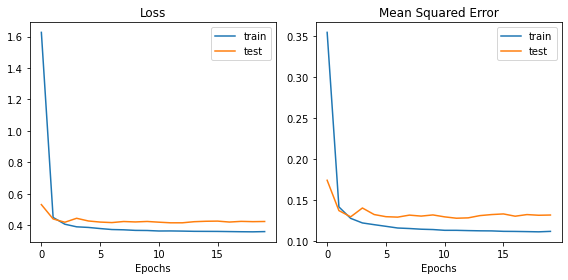

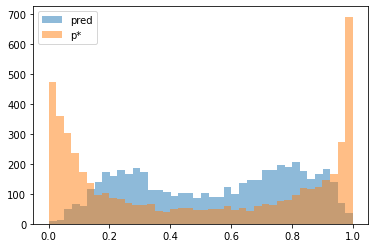

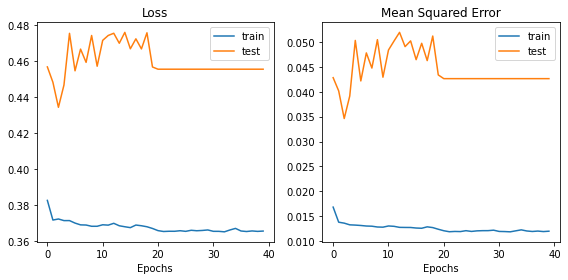

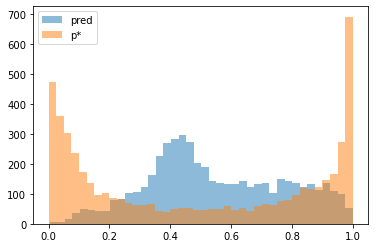

0.22218972489328817
0.20162800491475902
0.3929938654813169
0.3841692475878786


In [335]:
# Convert history lists to dictionaries
total_hist1 = dict()
total_hist2 = dict()

for key in hists1[0].history.keys():
    current_values = [] 
    for hist_dict in hists1:
        hist_dict = hist_dict.history
        current_values += hist_dict[key]
    total_hist1[key] = current_values
    
for key in hists2[0].history.keys():
    current_values = [] 
    for hist_dict in hists2:
        hist_dict = hist_dict.history
        current_values += hist_dict[key]
    total_hist2[key] = current_values
    
fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].plot(total_hist1['loss'], label='train')
ax[0].plot(total_hist1['val_loss'], label='test')
ax[0].legend()
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")


ax[1].plot(total_hist1['mean_squared_error'], label='train')
ax[1].plot(total_hist1['val_mean_squared_error'], label='test')
ax[1].legend()
ax[1].set_title("Mean Squared Error")
ax[1].set_xlabel("Epochs")

plt.tight_layout()
plt.show()

plt.hist(lenet_5_model.predict(X_test), label='pred', alpha=0.5, bins=40)
plt.hist(p_star_test, label='p*', alpha=0.5, bins=40)
plt.legend()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].plot(total_hist2['loss'], label='train')
ax[0].plot(total_hist2['val_loss'], label='test')
ax[0].legend()
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")


ax[1].plot(total_hist2['mean_squared_error'], label='train')
ax[1].plot(total_hist2['val_mean_squared_error'], label='test')
ax[1].legend()
ax[1].set_title("Mean Squared Error")
ax[1].set_xlabel("Epochs")

plt.tight_layout()
plt.show()

plt.hist(model.predict(X_test), label='pred', alpha=0.5, bins=40)
plt.hist(p_star_test, label='p*', alpha=0.5, bins=40)
plt.legend()
plt.show()

print(mse(lenet_5_model.predict(X_test), p_star_test))
print(mse(model.predict(X_test), p_star_test))

print(mae(lenet_5_model.predict(X_test), p_star_test))
print(mae(model.predict(X_test), p_star_test))

In [56]:
small_resnet = tf.keras.applications.ResNet50(
    include_top=False, weights=None, input_tensor=None,
    input_shape=(32, 32, 1), pooling='max', classes=1,
    classifier_activation='sigmoid')

In [57]:
len(small_resnet.layers)

176